In [2]:
import matplotlib.pyplot as plt
from os import getcwd
import torch
from numpy import linspace, logspace, savetxt, column_stack
from tqdm import tqdm
from torch.distributions import multivariate_normal

from algorithm_package.algorithm_package import paper_algorithm
from energy_package.energy_package import two_param
from rf_package.rf_package import planar_flow
from plot_animation_package.plot_animation_package import density_2D

import multiprocessing
from joblib import Parallel, delayed

In [3]:
def plot(beta, U, energy_parameters, model_file, renormalization_flow, base_distribution):

    flow = renormalization_flow
    flow.load_state_dict(torch.load(model_file+'\\model.pt'))
    flow.eval()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

    xlim = [-15,15]
    ylim = xlim
    x = torch.linspace(* xlim,200)
    y = torch.linspace(*ylim,200)

    xx, yy = torch.meshgrid(x,y)

    def log_rho_hat(x):
        return base_distribution.log_prob((flow.inverse(x))[0]) + flow.inverse(x)[1]

    z_flow = torch.exp(log_rho_hat(torch.stack([xx, yy], dim=-1).reshape(-1, 2)).detach()).reshape(xx.shape)
    z_flow_norm = z_flow / torch.sum(z_flow)+1e-15
    
    ax1.pcolormesh(xx.numpy(),yy.numpy(),z_flow_norm.numpy())
    ax1.set_title('Flow distribution')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    z_target = torch.exp(-beta*U(torch.stack([xx, yy]), energy_parameters))
    z_target_norm = z_target / torch.sum(z_target)+1e-15
    
    ax2.pcolormesh(xx.numpy(),yy.numpy(),z_target_norm.numpy())
    ax2.set_title('Target distribution')
    ax2.set_xlabel('x')

    # Compute KL Divergence
    kl_div = torch.sum(z_flow_norm * torch.log(z_flow_norm / z_target_norm))
    
    fig.savefig(model_file+'.png')

    return kl_div

In [5]:
import torch
from torch.distributions.uniform import Uniform

class MultivariateUniform(Uniform):
    def __init__(self, low, high, data_dim):
        super(MultivariateUniform, self).__init__(low, high)
        self.data_dim = data_dim

    def sample(self):
        return super().sample(torch.Size([self.data_dim]))

    def log_prob(self, value):
        if value.dim() < 1 or value.size(-1) != self.data_dim:
            raise ValueError("Last dimension of value must be of size data_dim")

        # Calculate log_prob for each dimension and sum them
        log_prob_per_dim = super().log_prob(value)
        return log_prob_per_dim.sum(-1)

import torch
from torch.autograd import grad

# Create a MultivariateUniform distribution instance
data_dim = 3
low = torch.tensor(0.0, requires_grad=True)
high = torch.tensor(1.0, requires_grad=True)
uniform_dist = MultivariateUniform(low, high, data_dim)

# Generate a sample
sample = uniform_dist.sample()

# Compute log probability
log_prob = uniform_dist.log_prob(sample)

# Calculate gradients
gradient_low = grad(log_prob, low, retain_graph=True)[0]
gradient_high = grad(log_prob, high)[0]

print("Sample:", sample)
print("Log Probability:", log_prob)
print("Gradient with respect to low:", gradient_low)
print("Gradient with respect to high:", gradient_high)


Sample: tensor([0.0998, 0.5722, 0.0900])
Log Probability: tensor(0., grad_fn=<SumBackward1>)
Gradient with respect to low: tensor(3.)
Gradient with respect to high: tensor(-3.)


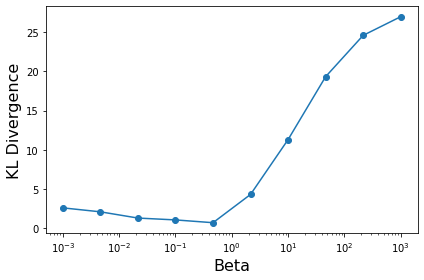

In [16]:
#torch.manual_seed(0)
beta_list = logspace(-3,3,10)

# MODEL PARAMETERS
data_dim = 2 #size of the parameter space
beta = 1
U = two_param.bistable_circle
BC = two_param.bistable_circle_BC
energy_parameters = []

# RF PARAMETERS
base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=torch.eye(data_dim))
#base_distribution = MultivariateUniform(-15, 15, data_dim)
renormalization_flow = planar_flow.LayeredPlanarFlow(data_dim)
epsilon = 2e-2 #gradient descent rate for RF parameters
n = 20 #number of initial samples

# MALA PARAMETERS
time_step = 1e-1
k_lang = 200
k_max = 200

# INITIALISATION
initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*20-10
#initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*10

base_file = 'multivariate_normal-LayeredPlanarFlow-beta'

def computation(beta):
    model_name = base_file+"\\beta"+'{}'.format(beta)
    model_file = getcwd()+"\\saved_models"+"\\"+model_name
    RF_MCMC_parameters = [time_step, k_max, k_lang, epsilon]
    history, array_of_model_configurations = paper_algorithm.NF_MCMC_algorithm(model_name, beta, U, BC, energy_parameters, renormalization_flow, initial_data, base_distribution, *RF_MCMC_parameters)
    
    kl_div = plot(beta, U, energy_parameters, model_file, renormalization_flow, base_distribution)
    return kl_div

num_cores = multiprocessing.cpu_count()
with Parallel(n_jobs=num_cores) as parallel:
    kl_div_list = parallel(delayed(computation)(beta) for beta in beta_list)

txt_file = getcwd()+"\\saved_models"+"\\"+base_file+"\\beta.txt"
savetxt(txt_file, column_stack((beta_list, kl_div_list)), delimiter="\t", header="layer\tkl_div")

fig, ax = plt.subplots()

ax.set_xlabel('Beta', fontsize=16)
ax.set_ylabel('KL Divergence', fontsize=16)
ax.scatter(beta_list, kl_div_list)
ax.plot(beta_list, kl_div_list)
ax.set_xscale('log')
plt.tight_layout()
fig.savefig(getcwd()+"\\saved_models"+"\\"+base_file+'\\beta')